In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap
import seaborn as sns
import plotly.express as px
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import calendar
import requests
from sklearn.compose import ColumnTransformer
import json
import joblib

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
from utils.weather_utils import query_temperatures, count_temperatures_above_threshold, create_country_coordinates_dict, create_dates


In [3]:
directory = '../data/raw/'
top_countries_valid_death = pd.read_csv('../data/processed/country_focus.csv')
top_countries_valid_death.head()

,Unnamed: 0,Dis No,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damages ('000 US$),"Insured Damages, Adjusted ('000 US$)",Total Damages ('000 US$),"Total Damages, Adjusted ('000 US$)",CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,192,1985-0257-GRC,1985,257,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,...,NaN,NaN,NaN,NaN,NaN,36.755468,NaN,NaN,NaN,NaN
1,209,1987-0596-GRC,1987,596,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,...,NaN,NaN,NaN,NaN,NaN,38.825601,NaN,NaN,NaN,NaN
2,217,1988-0298-GRC,1988,298,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,...,NaN,NaN,NaN,NaN,NaN,40.408806,NaN,NaN,NaN,NaN
3,371,1990-0085-FRA,1990,85,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,...,NaN,NaN,NaN,NaN,NaN,44.645877,NaN,NaN,NaN,NaN
4,543,1995-0157-ESP,1995,157,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,...,NaN,NaN,NaN,NaN,NaN,52.069299,NaN,NaN,NaN,NaN



# Process data and add Eurostat features

In [4]:
class EurostatFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, files, two_to_three_iso):
        self.files = files
        self.two_to_three_iso = two_to_three_iso

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        new_features = X[['ISO']].copy()

        for file in self.files:
            df_health = pd.read_csv(directory + file + '.csv')
            
            if file == 'disabled':
                df_health = df_health[df_health['assist'] == 'TOTAL']

            df_health['geo'] = df_health['geo'].map(self.two_to_three_iso)
            df_health_2022 = df_health[df_health['TIME_PERIOD'] == df_health['TIME_PERIOD'].max()]
            df_filtered = df_health_2022[['geo', 'OBS_VALUE']]
            df_filtered.columns = ['ISO', file]
            new_features = pd.merge(new_features, df_filtered, how='left', on='ISO')
        
        new_features = new_features.drop_duplicates(keep='first')
        return pd.merge(X, new_features, how='left', on='ISO')

class NonConstantColumnSelector(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = []
        for column in X.columns:
            unique_values = X[column].nunique()

            if unique_values > 1:
                result.append(column)
        
        return X[result]

class RemoveColumnsWithAllNA(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.columns_to_keep = X.columns[X.notna().any()]
        return self
    def transform(self, X):
        return X[self.columns_to_keep]

class CalculateDuration(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()

        mask = X_copy['Start Day'].notna() & X_copy['End Day'].notna()

        X_copy['Start Date'] = pd.to_datetime(dict(year=X_copy['Start Year'], month=X_copy['Start Month'], day=X_copy['Start Day']))
        X_copy['End Date'] = pd.to_datetime(dict(year=X_copy['End Year'], month=X_copy['End Month'], day=X_copy['End Day']))
        X_copy['Duration'] = X_copy['End Date'] - X_copy['Start Date']      
        X_copy['Duration'] = X_copy['Duration'].apply(lambda x: x.days if not pd.isnull(x) else np.nan)

        return X_copy

remove_na_cpi = FunctionTransformer(lambda df: df.dropna(subset=['CPI']), validate=False)

In [5]:
files = ['poverty', 'housing_deprive', 'forest', 'elder', 'population', 'gdp',
         'unemployment', 'child_population', 'disabled']

file_path = directory +"two_to_three_iso.json"
with open(file_path, 'r') as json_file:
    two_to_three_iso = json.load(json_file)

file_path = directory +"country_capitals.json"
with open(file_path, 'r') as json_file:
    capitals = json.load(json_file)

In [6]:
def harmonize_iso(two_to_three_iso):
    new_key = 'GR'
    value = two_to_three_iso['EL']    
    two_to_three_iso[new_key] = value    
    del two_to_three_iso['EL']

    return two_to_three_iso

In [7]:
#    #two_to_three_iso['RU'] = 'RUS'   

In [8]:
two_to_three_iso = harmonize_iso(two_to_three_iso)

In [9]:
pipeline_one = Pipeline(steps=[
    ('remove_na_cpi', remove_na_cpi),
    ('remove_na_col', RemoveColumnsWithAllNA()),
    ('calculate_duration', CalculateDuration()),
    ('non_constant_col_selector', NonConstantColumnSelector()),
    ('eurostat_features', EurostatFeatureExtractor(files=files, two_to_three_iso=two_to_three_iso))
])

transformed_df = pipeline_one.fit_transform(top_countries_valid_death)

In [10]:

class AddWeatherFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, capitals, two_to_three_iso, threshold, relevant_iso):
        self.capitals = capitals
        self.two_to_three_iso = two_to_three_iso
        self.relevant_iso = relevant_iso
        self.threshold = threshold

    def fit(self, X, y=None):
        self.country_coordinates_dict = create_country_coordinates_dict(self.capitals, self.two_to_three_iso, self.relevant_iso)
        return self

    def transform(self, X):
        dfs = X.copy()
        dfs['Start_Date'], dfs['End_Date'] = zip(*dfs.apply(create_dates, axis=1))
        
        for index, row in dfs.iterrows():
            start_date = row['Start_Date']
            end_date = row['End_Date']

            code = row['ISO']
            if code in self.country_coordinates_dict:
                lat = self.country_coordinates_dict[code]['CapitalLatitude']
                lon = self.country_coordinates_dict[code]['CapitalLongitude']

                temperatures = query_temperatures(lat, lon, start_date, end_date)
                above_threshold_count = count_temperatures_above_threshold(temperatures, self.threshold)
                max_temperature = max(temperatures) if temperatures else None

                dfs.loc[index, 'Days_over_30'] = above_threshold_count
                dfs.loc[index, 'Max_temp'] = max_temperature
            else:
                print(f"Data missing for ISO code: {code}")
        
        return dfs

class Remove_nan_rows(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X[~X['Max_temp'].isna()]
        X = X[~X['child_population'].isna()]
        X = X[~X['disabled'].isna()]
        return X

class Create_percentage(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['child_population'] =X['child_population'] *100 /X['population'] 
        X['disabled'] =X['disabled'] * 100/X['population'] 

        return X

In [11]:
relevant_iso = list(transformed_df.ISO.unique())
threshold = 30

pipeline_two = Pipeline(steps=[
    ('weather_features', AddWeatherFeatures(capitals =capitals, two_to_three_iso=two_to_three_iso, 
                                             threshold=threshold, relevant_iso=relevant_iso)),
    ('remove_nan_rows', Remove_nan_rows()),
    ('create_percentage', Create_percentage())
])

df_model = pipeline_two.fit_transform(transformed_df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data missing for ISO code: RUS
Data missing for ISO code: RUS
Data missing for ISO code: RUS


# Add weather

# Modelling

In [12]:
df_model.shape

(49, 43)

In [13]:
#df_model.to_csv('df_model.csv')

In [14]:
features = ['Year', 'Country', 'Seq', # 'month_length',
  #  'Duration',
           'Max_temp',
          'Days_over_30', 'Start Month',
            'Region', 
          #  'Continent'
          #  'CPI',
           ] + files

df = df_model[features]

columns_to_encode = ['Region','Country']

dummies = pd.get_dummies(df[columns_to_encode], columns=columns_to_encode, prefix=columns_to_encode)

In [15]:
df.head()

,Year,Country,Seq,Max_temp,Days_over_30,Start Month,Region,poverty,housing_deprive,forest,elder,population,gdp,unemployment,child_population,disabled
3,1990,France,85,32.1,2.0,7.0,Western Europe,21.0,3.8,32.8,21.0,67871925.0,33180.0,2.0,17.499337,0.010027
4,1995,Spain,157,40.3,20.0,7.0,Southern Europe,26.0,3.4,41.2,20.1,47432893.0,24580.0,5.0,13.973293,0.013811
5,1998,Italy,204,35.3,15.0,7.0,Southern Europe,24.4,6.1,37.0,23.8,59030133.0,27860.0,4.6,12.688088,0.012535
7,1996,Romania,362,36.4,11.0,7.0,Eastern Europe,34.4,14.3,35.5,19.5,19042455.0,10110.0,2.2,16.221769,0.017139
8,1998,Romania,250,37.1,13.0,8.0,Eastern Europe,34.4,14.3,35.5,19.5,19042455.0,10110.0,2.2,16.221769,0.017139


In [16]:
X = pd.concat([df, dummies], axis=1).drop(columns_to_encode, axis=1)
y = df_model['Total Deaths'] 

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=42)


In [31]:
#X.to_csv('../data/processed/model_ready.csv', index=None)
X.head()

,Year,Seq,Max_temp,Days_over_30,Start Month,poverty,housing_deprive,forest,elder,population,...,Country_Belgium,Country_Bulgaria,Country_France,Country_Germany,Country_Italy,Country_Netherlands,Country_Portugal,Country_Romania,Country_Slovakia,Country_Spain
3,1990,85,32.1,2.0,7.0,21.0,3.8,32.8,21.0,67871925.0,...,False,False,True,False,False,False,False,False,False,False
4,1995,157,40.3,20.0,7.0,26.0,3.4,41.2,20.1,47432893.0,...,False,False,False,False,False,False,False,False,False,True
5,1998,204,35.3,15.0,7.0,24.4,6.1,37.0,23.8,59030133.0,...,False,False,False,False,True,False,False,False,False,False
7,1996,362,36.4,11.0,7.0,34.4,14.3,35.5,19.5,19042455.0,...,False,False,False,False,False,False,False,True,False,False
8,1998,250,37.1,13.0,8.0,34.4,14.3,35.5,19.5,19042455.0,...,False,False,False,False,False,False,False,True,False,False


In [18]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

rf_model = RandomForestRegressor(n_estimators=400)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

y_pred_train = rf_model.predict(X_train)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

X_train shape: (34, 27)
X_test shape: (15, 27)
y_train shape: (34,)
y_test shape: (15,)
Mean Squared Error (MSE): 2855788.7322691665
Root Mean Squared Error (RMSE): 1689.9079064461373
Mean Absolute Error (MAE): 1262.2076666666665
R-squared (R2): 0.6876293568829739


In [19]:
image_folder = '../images/'

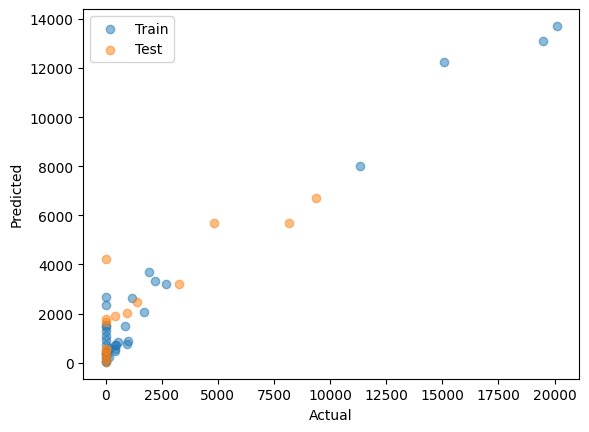

In [20]:
plt.scatter(y_train, y_pred_train, alpha=0.5, label='Train')
plt.scatter(y_test, y_pred, alpha=0.5, label='Test')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()  
plt.savefig(image_folder + 'predicted_actual.png')  

plt.show()

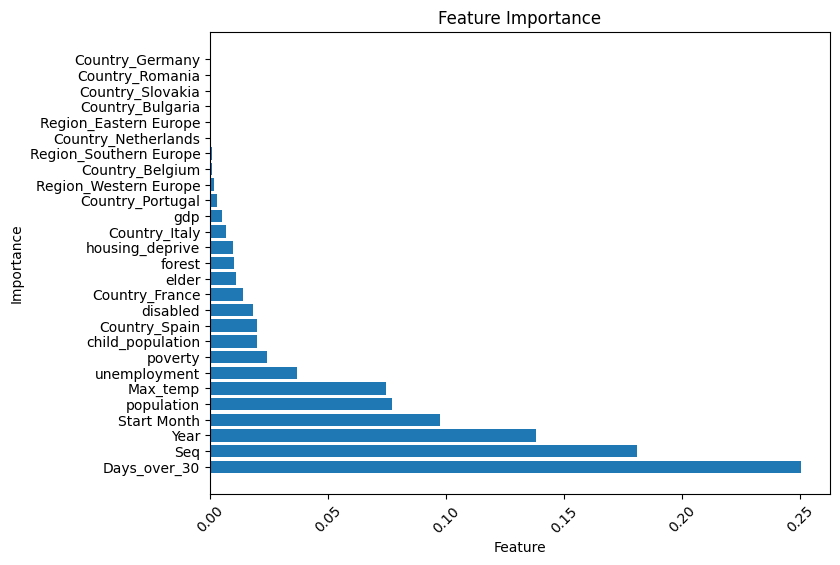

In [21]:
importances = rf_model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)

plt.savefig(image_folder + 'feature_importance.png')  # Replace with the desired image file format

plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


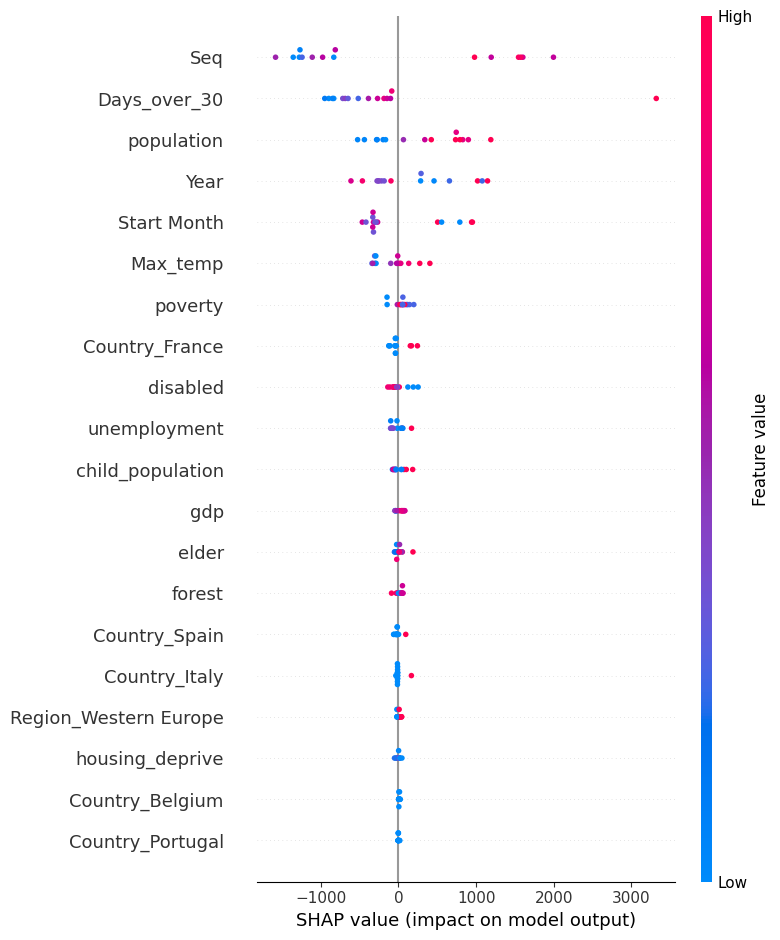

<Figure size 640x480 with 0 Axes>

In [22]:
explainer = shap.Explainer(rf_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)

plt.savefig(image_folder + 'shap_summary_plot.png')

In [27]:
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [28]:
loaded_model = joblib.load('random_forest_model.pkl')

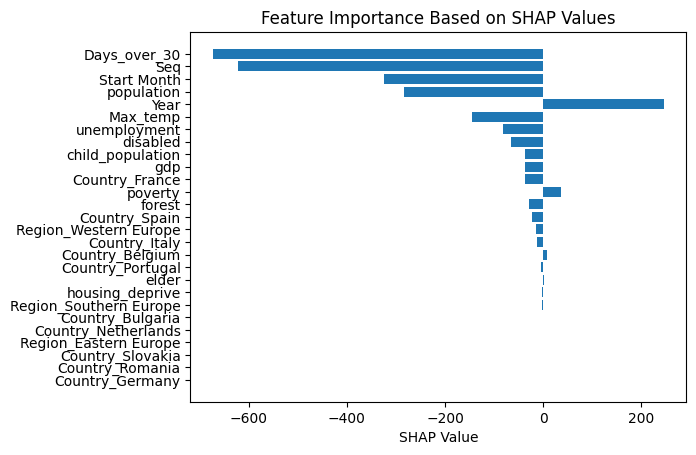

In [29]:
index = 5  
observation = X.iloc[index]
explainer = shap.Explainer(loaded_model)
shap_values = explainer.shap_values(observation)
feature_names = X.columns
sorted_indices = np.argsort(np.abs(shap_values))
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_shap_values = [shap_values[i] for i in sorted_indices]

plt.barh(range(len(sorted_feature_names)), sorted_shap_values, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('SHAP Value')
plt.title('Feature Importance Based on SHAP Values')
plt.savefig(image_folder + 'explain_one_obs.png')
plt.show()